In [ ]:
import glob
import os
import GPUtil

import subprocess
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = subprocess.check_output('nvidia-smi | grep "$(cat /tmp/couaironpgpu)" | awk \'{print $2}\'', shell=True, text=True).strip()
print(os.environ["CUDA_VISIBLE_DEVICES"])

import torch
import torch.nn.functional as F
import torchvision.transforms as T

from PIL import Image

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns

import numpy as np
from ldm import LdmExtractor
from tqdm.notebook import tqdm_notebook as tqdm

from diffcut import DiffCut

from pamr import PAMR
from scipy.ndimage import median_filter

os.environ['http_proxy'] = "http://192.168.0.100:3128"
os.environ['https_proxy'] = "http://192.168.0.100:3128"

In [2]:
def mask_refinement(labels, image):
    masks = torch.cat([1. * (labels == label) for label in torch.unique(labels)], dim=1)
    # num_iter and dilations impact final result
    labels = PAMR(num_iter=30, dilations=[1, 2, 4, 8, 12, 24, 32])(image, masks)

    labels = 1. * torch.argmax(labels, dim=1)
    labels = median_filter(labels.cpu().numpy(), 3).astype(int)

    return labels

### Load Diffusion Model

In [3]:
extractor = LdmExtractor(model_name="SSD-1B", inverse_scheduler=None)

Loading SD model


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

SD model loaded


#### __Diffusion Features Extraction__

In [4]:
img_path = "./assets/coco.jpg"

pil_img = Image.open(img_path).convert('RGB')
image = T.ToTensor()(pil_img).unsqueeze(0).to("cuda")
_, _, h, w = image.shape

img_size = 1024 # 2048

resized_image = F.interpolate(image, size=(img_size, img_size), mode='bilinear')
batched_input = {'img': torch.cat([resized_image], dim=0), 'caption': [""]}

# Diffusion Timesteps
t = 50
diffusion_features = extractor(batched_input, guidance_scale=1., n_steps=10, steps=(t,), encode_method="noise")

# Output features from the final self-attention block of the UNet encoder
features = diffusion_features['down_blocks.2.attentions.1.transformer_blocks.3']

/home/couaironp/.local/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


#### __Zero-Shot Image Segmentation__

In [9]:
# Hyperparameters
tau = 0.5
alpha = 10

# Recursive Feature Clustering
feats = features.reshape(1, img_size//32, img_size//32, -1).permute(0, 3, 1, 2).to(torch.float32)
feats_norm = F.normalize(feats, dim=1)
diffcut  = DiffCut()

masks = diffcut.generate_masks(feats_norm, tau=tau, mask_size=(h, w), alpha=alpha)
masks = torch.Tensor(masks).to("cuda")

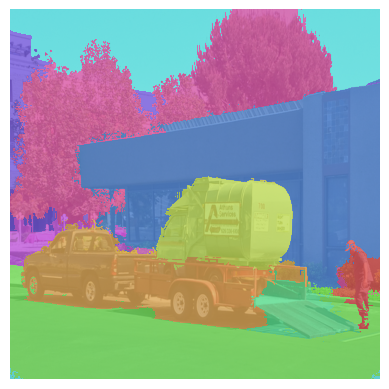

In [10]:
# Mask Refinement
image = F.interpolate(image, size=(img_size, img_size), mode='bilinear')
new_mask = mask_refinement(masks, image)

colors = sns.hls_palette(len(np.unique(new_mask)), h=0.9)
permuted_cmap = ListedColormap(colors)

plt.imshow(image.cpu()[0].permute(1, 2, 0))
plt.imshow(new_mask[0], cmap=permuted_cmap, interpolation='nearest', alpha=0.8)
plt.axis("off");